In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
# Using module Pendulum to facilitate the operations when using dates
import pendulum

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
# Reflect Database into ORM classes
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
# Measurements
Measurements = Base.classes.measurement
# Stations
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()[0]

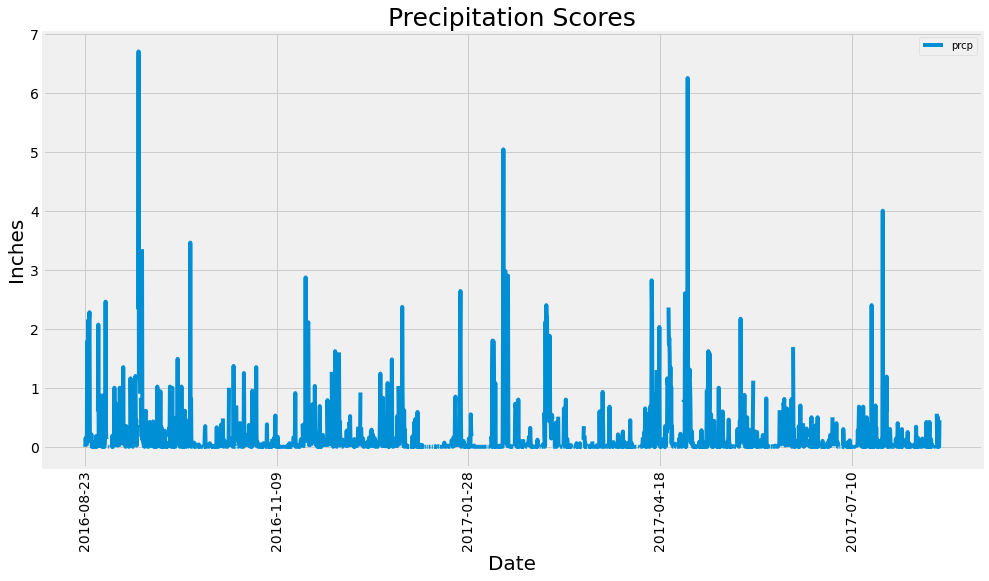

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
dt = pendulum.parse(most_recent_date)  # creating a DataTime object type using pendulum module

# Calculate the date one year from the last date in data set.
previous_year = dt.subtract(years=1).to_date_string()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= previous_year).\
    order_by(Measurements.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(results, session.bind)
df.set_index("date", inplace=True)

# Sort the dataframe by date
df.sort_values(by='date', ascending=True, inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(rot=90, figsize=(15,8), fontsize=14)
ax.set_title("Precipitation Scores", fontsize=25)
ax.set_ylabel("Inches", fontsize=20)
ax.set_xlabel("Date", fontsize=20);
plt.savefig("Output_Data/precipitation.png", bbox_inches = 'tight')


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Stations.station).count()
print(f'The total number of stations is {total_stations}')

The total number of stations is 9


In [69]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_activity = session.query(Measurements.station, func.count(Measurements.station)).group_by(Measurements.station).\
order_by(func.count(Measurements.station).desc()).all()

for station in stations_activity:
    print(f"Station: {station[0]} --- Count: {station[1]}")
top_station = stations_activity[0]
print(f"\nThe Most Active Station is {top_station[0]} with {top_station[1]} counts in total from {dt.to_date_string()} to \
{dt.add(years=1).to_date_string()}")

Station: USC00519281 --- Count: 2772
Station: USC00519397 --- Count: 2724
Station: USC00513117 --- Count: 2709
Station: USC00519523 --- Count: 2669
Station: USC00516128 --- Count: 2612
Station: USC00514830 --- Count: 2202
Station: USC00511918 --- Count: 1979
Station: USC00517948 --- Count: 1372
Station: USC00518838 --- Count: 511

The Most Active Station is USC00519281 with 2772 counts in total from 2017-08-23 to 2018-08-23


In [76]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Where top_station[0] = USC00519281 
station_stats = session.query(func.min(Measurements.tobs),func.max(Measurements.tobs), func.avg(Measurements.tobs))\
.filter(Measurements.station == top_station[0]).all()[0]
min_temp, max_temp, avg_temp = station_stats

print(f"At station {top_station[0]} these are the next statistics from {dt.to_date_string()} to {dt.add(years=1).to_date_string()}\n")
print(f"Minimum Temperature: {min_temp}")
print(f"Maximum Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")




At station USC00519281 these are the next statistics from 2017-08-23 to 2018-08-23

Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66378066378067


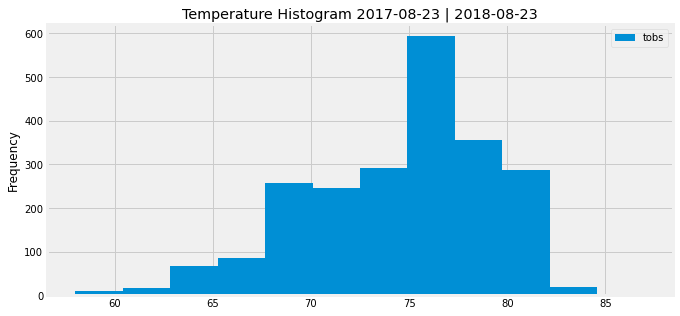

In [88]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_tobs = session.query(Measurements.date, Measurements.tobs).filter(Measurements.date >= previous_year).\
    order_by(Measurements.date).statement

# Save the query results as a Pandas DataFrame
top_tobs_df = pd.read_sql_query(top_station_tobs, session.bind)

# Histogram Title 
title = f"Temperature Histogram {dt.to_date_string()} | {dt.add(years=1).to_date_string()}"

ax = top_tobs_df.plot.hist(bins=12, title=, figsize=(10,5))

# Close session

In [16]:
# Close Session
session.close()